In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from skimage import io
import seaborn as sns
from random import sample

from itertools import chain
#from random import choice
import scipy

import sklearn.metrics
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
38457,00010052_003.png,No Finding,3,10052,27,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010052_003.png
12561,00003283_000.png,Cardiomegaly,0,3283,58,M,PA,2766,2665,0.143,0.143,NaN,/data/images_002/images/00003283_000.png
96343,00025362_000.png,Mass,0,25362,49,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00025362_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

## Going to split up "Finding Labels" column so that there's one column in the dataframe
# per disease, with a binary flag. This makes EDA easier 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81117,00019924_009.png,Atelectasis|Effusion,9,19924,56,F,PA,2758,2708,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95419,00025084_000.png,Infiltration,0,25084,23,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82300,00020234_002.png,No Finding,2,20234,29,M,AP,2784,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'Pneumonia' if x==1.0 else 'No pneumonia')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
23893,00006296_037.png,No Finding,37,6296,15,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No pneumonia
49468,00012549_008.png,Atelectasis,8,12549,60,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No pneumonia
92009,00022961_008.png,Atelectasis|Effusion|Infiltration|Pneumonia,8,22961,61,F,PA,2700,2318,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia


In [5]:
#Remove age outliers (max age incorrectly shows 414)
df = all_xray_df[all_xray_df['Patient Age'] < 130]
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0,112104.000000,112104.000000,...,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN,0.103101,0.024763,...,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN,0.304092,0.155402,...,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create your training and testing data:

In [6]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['Pneumonia'])
    
    return train_data, val_data

In [7]:
train_data, val_data = create_splits(df)

In [8]:
train_data['Pneumonia'].sum()/len(train_data)

0.012756040721206917

In [9]:
val_data['Pneumonia'].sum()/len(val_data)

0.01275589848802462

Great, our train_test_split made sure that we had the same proportions of Pneumonia in both sets!

#### Condition 1 - To have EQUAL amount of positive and negative cases of Pneumonia in Training dataset

But we want the model to be trained on a set that has equal proportions of Pneumonia and no Pneumonia, so I'm going to throw away some data:

In [10]:
p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [11]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

I randomly chose a set of non-Pneumonia images using the sample() function that was the same length as the number of true Pneumonia cases we had, and threw out the rest of the non-Pneumonia cases. Now the training dataset is balanced 50-50.

#### Condition 2 - To have 20% positive cases of Pneumonia in the Test Set

Finally, we want to make the balance in the validation set 20-80

In [12]:
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]

In [13]:
val_data['Pneumonia'].sum()/len(val_data)

0.2

In [14]:
len(train_data)

2288

In [15]:
len(val_data)

1430

### Training dataset EDA

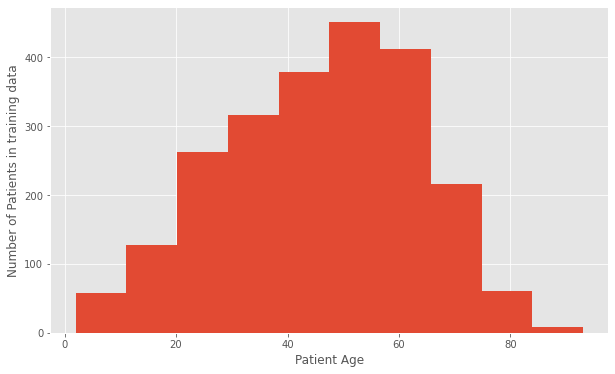

In [44]:
#Patient age distribution

plt.figure(figsize=(10,6))
plt.hist(train_data['Patient Age'])
plt.ylabel('Number of Patients in training data')
plt.xlabel('Patient Age')
plt.savefig('train_age.png')
plt.show()

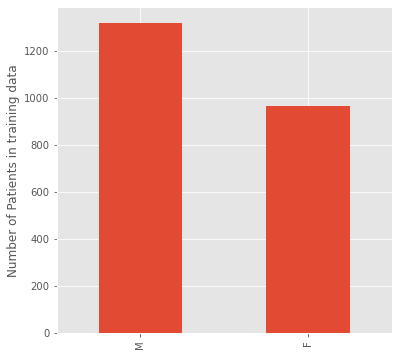

In [45]:
plt.figure(figsize=(6,6))
train_data['Patient Gender'].value_counts().plot(kind='bar')

plt.ylabel('Number of Patients in training data')
plt.savefig('train_gender.png')
plt.show()

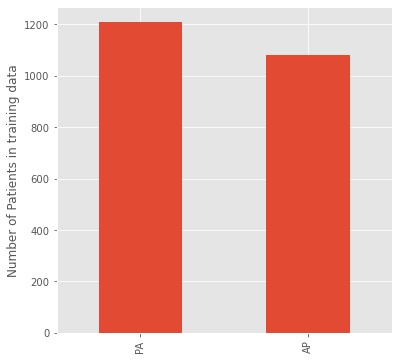

In [46]:
#Xray view position/patient position distribution:

plt.figure(figsize=(6,6))
train_data['View Position'].value_counts().plot(kind='bar')

plt.ylabel('Number of Patients in training data')
plt.savefig('train_position.png')
plt.show()

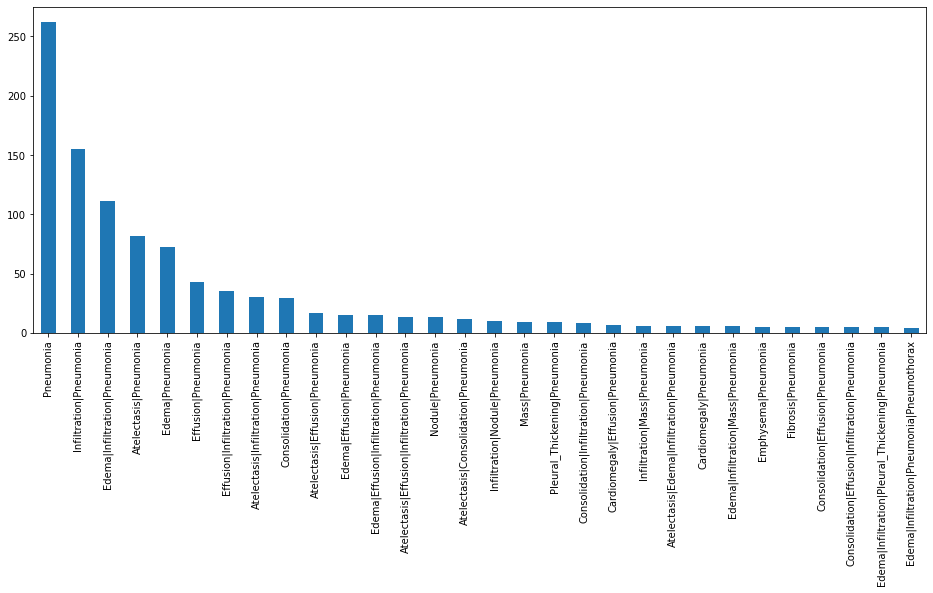

In [16]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
train_data[train_data.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.savefig('train_cooccurence.png')

### EDA on Validation dataset

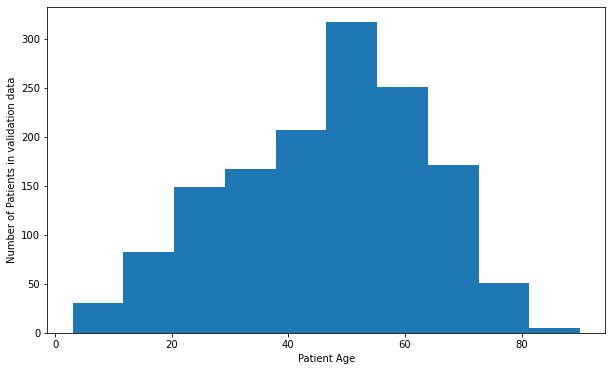

In [17]:
#Patient age distribution

plt.figure(figsize=(10,6))
plt.hist(val_data['Patient Age'])
plt.ylabel('Number of Patients in validation data')
plt.xlabel('Patient Age')
plt.savefig('val_age.png')
plt.show()

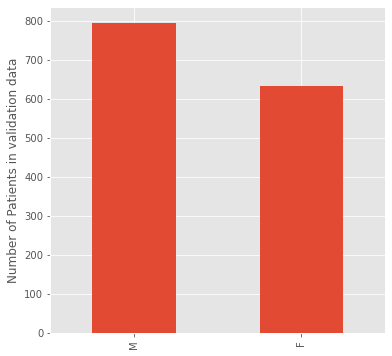

In [49]:
plt.figure(figsize=(6,6))
val_data['Patient Gender'].value_counts().plot(kind='bar')

plt.ylabel('Number of Patients in validation data')
plt.savefig('val_gender.png')
plt.show()

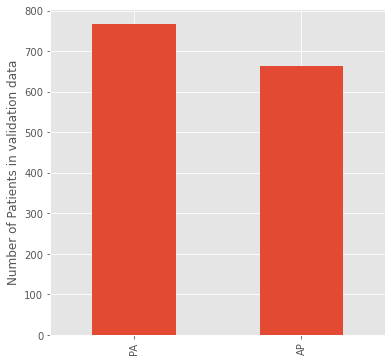

In [50]:
#Xray view position/patient position distribution:

plt.figure(figsize=(6,6))
val_data['View Position'].value_counts().plot(kind='bar')

plt.ylabel('Number of Patients in validation data')
plt.savefig('val_position.png')
plt.show()

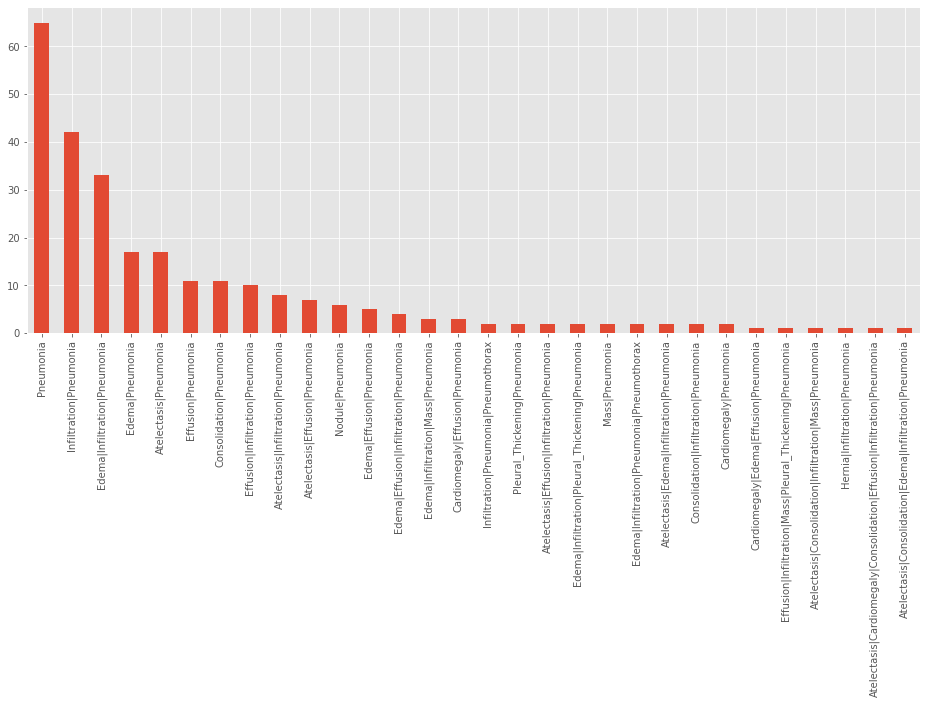

In [51]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
val_data[val_data.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.savefig('val_cooccurence.png')

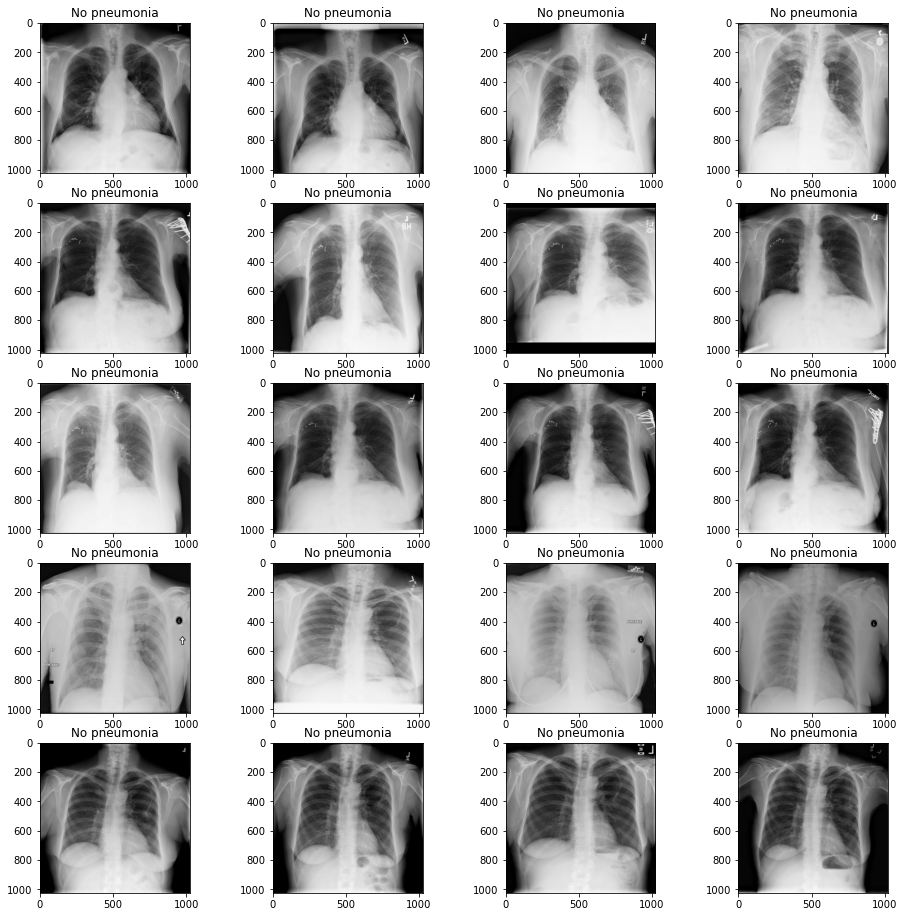

In [14]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df.iloc[ind]['pneumonia_class'])
    ind=ind+1

In [14]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(preprocessing_function = preprocess_input,      #replaced rescale=1. / 255.0 with preprocess_input
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)


    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    my_train_idg = my_image_augmentation(train_data)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 64
                                         )
    
    return train_gen

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
def val_preprocess(vargs):
    
    val_preprocess = ImageDataGenerator(preprocessing_function = preprocess_input)       #replaced rescale=1. / 255.0 with preprocess_input

    return val_preprocess


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo    
    
    my_val_idg = val_preprocess(val_data)

    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 100
                                         ) 
    
    return val_gen

In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)
valX, valY = next(val_gen)

Found 1430 validated image filenames belonging to 2 classes.


In [16]:
train_gen = make_train_gen(train_data)
t_x, t_y = next(train_gen)
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())   #to be used for inference pre-processing, found on a knowledge post

Found 2288 validated image filenames belonging to 2 classes.
Train -123.68 151.061 4.667375 67.51837


Found 2288 validated image filenames belonging to 2 classes.


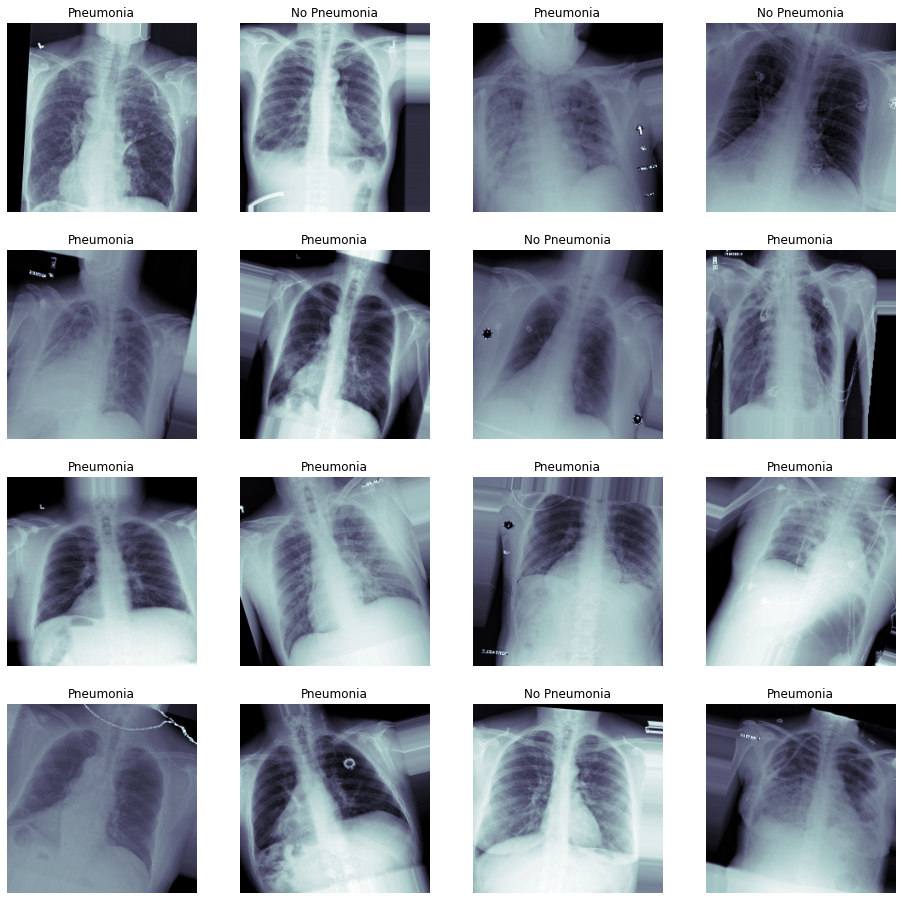

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

fig, m_axs = plt.subplots(4, 4, figsize = (16,16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
     #model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    

    model=VGG16(include_top=True,weights='imagenet')
    print(model.summary())

    transfer_layer=model.get_layer('block5_pool')

    vgg_model=Model(inputs=model.input,outputs=transfer_layer.output)

## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:18]:
        layer.trainable=False



    return vgg_model


In [20]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatten, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model=Sequential()
    
# Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)
    
# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
    my_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    my_model.add(Dense(1024,activation='relu'))

    my_model.add(Dropout(0.5))

    my_model.add(Dense(512,activation='relu'))

    my_model.add(Dropout(0.5))

#     my_model.add(Dense(512,activation='relu'))

#     my_model.add(Dropout(0.3))
    
    my_model.add(Dense(256,activation='relu'))
    
    my_model.add(Dropout(0.5))

#     my_model.add(Dense(256,activation='relu'))
    
#     my_model.add(Dropout(0.5))
# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1,activation='sigmoid'))

    return my_model   

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
vgg_model=load_pretrained_model()

my_model = build_my_model(vgg_model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [23]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [25]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= 'auto', 
                      patience=6)

callbacks_list = [checkpoint, early]

### Start training! 

In [26]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen,               #(valX, valY) 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
36/36 [==============================] - 88s 2s/step - loss: 6.0720 - binary_accuracy: 0.5092 - val_loss: 0.5788 - val_binary_accuracy: 0.7615

Epoch 00001: val_loss improved from inf to 0.57881, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
36/36 [==============================] - 57s 2s/step - loss: 4.2456 - binary_accuracy: 0.5083 - val_loss: 0.5779 - val_binary_accuracy: 0.7364

Epoch 00002: val_loss improved from 0.57881 to 0.57793, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
36/36 [==============================] - 61s 2s/step - loss: 3.1255 - binary_accuracy: 0.5402 - val_loss: 0.8012 - val_binary_accuracy: 0.6049

Epoch 00003: val_loss did not improve from 0.57793
Epoch 4/20
36/36 [==============================] - 62s 2s/step - loss: 2.8173 - binary_accuracy: 0.5267 - val_loss: 0.8226 - val_binary_accuracy: 0.5091

Epoch 00004: val_loss did not improve from 0.57793
Epoch 5/20
36/36 [==============================] - 62s 2s/step - loss: 2.5339

#### I trained my model with several changes however they didn't perform well. I tried changing the learning rate, batch size, added more dense layers as well as added dropout layers, removed some layers etc. Also tried changing the dropout rate

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)                #removed batch_size = 60,

100/100 [==============================] - 5s 51ms/step


In [28]:
len(pred_Y)

100

In [29]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig('auc.png')

    ## what other performance statistics do you want to include here besides AUC?     
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    plt.savefig('prec_recall.png')
    
    return precision, recall, thresholds

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
   
#Also consider plotting the history of your model training:

# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    return

In [30]:
def plot_f1_threshold(t_y,p_y):

    precision, recall, thresholds = precision_recall_curve(t_y.astype(int), p_y)

    f1_scores = []

    for i in thresholds:

        f1 = f1_score(valY.astype(int), binarize(pred_Y,i))

        f1_scores.append(f1)

    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

    c_ax.plot(thresholds, f1_scores, label = 'F1 Score_threshold_plot')

    c_ax.legend()

    c_ax.set_xlabel('Threshold')

    c_ax.set_ylabel('F1 Score')

    plt.savefig('f1_thresh.png')
    
    return f1_scores

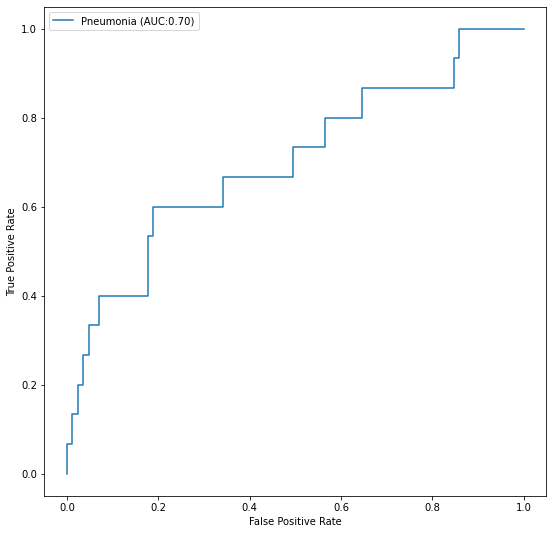

In [31]:
## plot figures
plot_auc(valY,pred_Y)

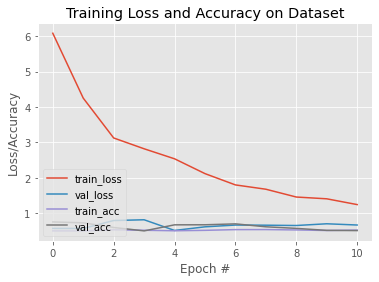

In [32]:
plot_history(history)

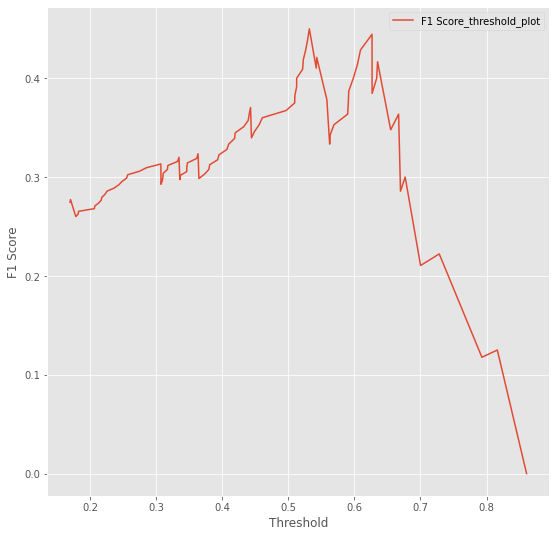

In [33]:
f1_scores = plot_f1_threshold(valY,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

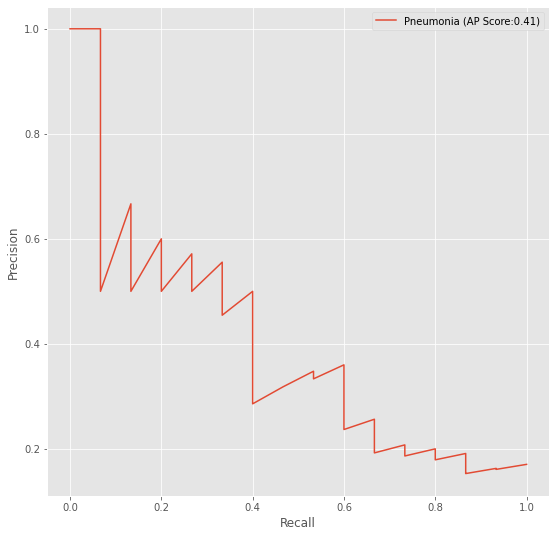

In [34]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = plot_precision_recall_curve(valY,pred_Y)

In [35]:
# Calculate best F1 Score and select corresponding threshold, precision and recall
print('Best F1-Score: ', np.max(f1_scores))
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Precision: ', precision[np.argmax(f1_scores)])
print('Recall: ', recall[np.argmax(f1_scores)])

Best F1-Score:  0.45
Best threshold:  0.53166294
Precision:  0.34615384615384615
Recall:  0.6


In [36]:
# add a new column with value 0 or 1 as predictions based on the threshold above

best_threshold = thresholds[np.argmax(f1_scores)]


my_model.load_weights(weight_path)
pred_Y = my_model.predict(val_gen, verbose = True) 

prediction_binary = [0]*1430

for i in range(1430):
    if pred_Y[i] > best_threshold:
        prediction_binary[i] = 1
        
val_data['algorithm_output'] = prediction_binary

15/15 [==============================] - 24s 2s/step


In [37]:
%store best_threshold

Stored 'best_threshold' (float32)


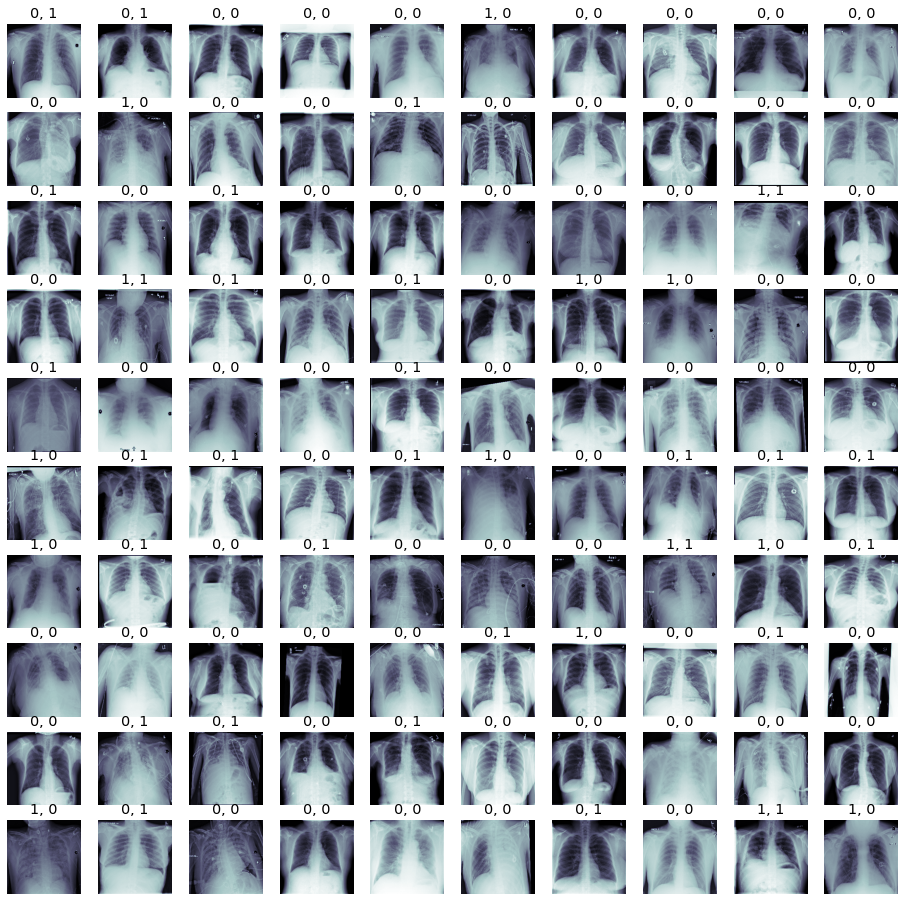

In [38]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [39]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

First, look at the overall performance of the algorithm for the detection of pneumonia:

In [40]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val_data.Pneumonia.values,
                                                  val_data.algorithm_output.values,labels=[0,1]).ravel()

In [41]:
sens = tp/(tp+fn)           #sensitivity
sens

0.25874125874125875

In [42]:
spec = tn/(tn+fp)           #specificity
spec

0.7587412587412588

Sensitivity of my algorithm is quite low, so it won't be able to detect pneumonia correctly.

Now, look at the algorithm's performance in the presence of the other diseases: 

In [43]:
for i in ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Edema','Mass','Nodule']:

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].algorithm_output.values,labels=[0,1]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()

Atelectasis
Sensitivity: 0.3111111111111111
Specificity: 0.7894736842105263

Effusion
Sensitivity: 0.21153846153846154
Specificity: 0.7795275590551181

Pneumothorax
Sensitivity: 0.2
Specificity: 0.7777777777777778

Infiltration
Sensitivity: 0.264
Specificity: 0.7295918367346939

Cardiomegaly
Sensitivity: 0.4444444444444444
Specificity: 0.6428571428571429

Edema
Sensitivity: 0.273972602739726
Specificity: 0.6666666666666666

Mass
Sensitivity: 0.18181818181818182
Specificity: 0.71875

Nodule
Sensitivity: 0.09090909090909091
Specificity: 0.8529411764705882



### Statement on algorithmic limitations:

The results above indicate that the presence of other diseases in a chest x-ray is a limitation of this algorithm, and that the algorithm performs very poorly on the accurate detection of pneumonia in the presence of other conditions such as, pneumothorax, and effusion. The presence of infiltration and edema have a slight impact on the algorithm's sensitivity and may reduce the ability to detect pneumonia, while the presence of effusion, mass, nodule has a slight impact on specificity and may increase the number of false positive pneumonia classifications.